In [6]:
import pandas as pd
import numpy as np
#Visualization
import matplotlib.pyplot as plt
import folium
import seaborn as sns
# Timeseries
import datetime
# xls files
import xlrd
# linear regression
from scipy import stats
from sklearn import metrics

# feature_eng: source 1 (COVID-19 confirmed cases)

In [56]:
# Read previous stored dataframe
covid19_global_data_cc = pd.read_csv('covid19_global_data_cc.csv')

In [57]:
# Function that return cases between min_ratio and max_ratio [%]
def get_covid19_global_data_cc(min_ratio, max_ratio):
    d = {}
    # run across all cc
    for cc in range(covid19_global_data_cc.shape[0]):
        peak_value = covid19_global_data_cc.iloc[cc,4:].max()
        max_value = covid19_global_data_cc.iloc[cc,4:].ge(peak_value*max_ratio)
        min_value = covid19_global_data_cc.iloc[cc,4:].ge(peak_value*min_ratio)

        if ((min_value.any() == True)&(max_value.any() == True)):
            plot = covid19_global_data_cc.iloc[cc,4:].cummax()[min_value.idxmax():max_value.idxmax()]
            # update cc values
            d.update({covid19_global_data_cc.iloc[cc,0]: [plot.values] })
    # dict -> dataframe
    dut = pd.DataFrame.from_dict(d, orient='index')
    dut.reset_index(inplace=True)
    # Unwrap pd. series
    dut_series = dut[0].apply(pd.Series)
    dut_series.rename(columns= lambda x: 'COVID19.DY.' + str(x),inplace=True)
    # Final dut 
    dut = pd.concat([dut['index'],dut_series],axis=1)
    dut.rename(columns={'index': 'iso3_cc'}, inplace=True)
    
    return(dut)

In [68]:
# Characterize slope with several stats metrics
#
# Evaluate COVID19 cases slope from 5% to 95%
dut = get_covid19_global_data_cc(0.05,0.95)

covid19_global_data_slope = pd.DataFrame()

# statistics performed over daily confirmed cases per country
covid19_global_data_slope['iso3_cc'] = dut.iloc[:,0]
# number of days elapsed from min_ratio to max_ratio
covid19_global_data_slope['COVID19.DYS'] = dut.iloc[:,1:].count(axis=1)
# mean value of confirmed daily cases
covid19_global_data_slope['COVID19.MEA'] = dut.iloc[:,1:].diff(axis=1).mean(axis=1)
# median value of confirmed daily cases
covid19_global_data_slope['COVID19.MED'] = dut.iloc[:,1:].diff(axis=1).median(axis=1)
# std deviation over confirmed daily cases
covid19_global_data_slope['COVID19.STD'] = dut.iloc[:,1:].diff(axis=1).std(axis=1)
# kurtosis value over confirmed daily cases (tail behavior)
covid19_global_data_slope['COVID19.KUR'] = dut.iloc[:,1:].diff(axis=1).kurt(axis=1)
# skewness value over confirmed daily cases (positive/neagtive, lack of symmetry )
covid19_global_data_slope['COVID19.SKW'] = dut.iloc[:,1:].diff(axis=1).skew(axis=1)

# linear regression to get: slope + incerceptor
for cc in range(0,dut.shape[0]):
    x = np.arange(0,dut.iloc[cc,1:].count())
    y = dut.iloc[cc,1:x.max()+2].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y.astype(float))
    covid19_global_data_slope.loc[cc,'COVID19.SLO'] = slope
    covid19_global_data_slope.loc[cc,'COVID19.INT'] = intercept

covid19_global_data_slope.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/jordi/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jordi/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/jordi/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [69]:
# Add country coordinates 
covid19_global_data_slope = pd.merge(covid19_global_data_slope, 
                                     covid19_global_data_cc[['iso3_cc','latitude','longitude']], 
                                     on='iso3_cc')

In [70]:
# rearrange column names
covid19_global_data_slope.rename(columns={'latitude': 'COVID19.LAT','longitude': 'COVID19.LNG'},inplace=True)
# 
covid19_global_data_slope.head()

,iso3_cc,COVID19.DYS,COVID19.MEA,COVID19.MED,COVID19.STD,COVID19.KUR,COVID19.SKW,COVID19.SLO,COVID19.INT,COVID19.LAT,COVID19.LNG
0,ABW,28,3.461538,3.0,3.325427,1.923327,1.249834,3.656814,6.704433,12.521110,-69.968338
1,AFG,34,67.656250,57.0,50.418001,2.799234,1.556547,59.197250,-93.342857,33.939110,67.709953
2,AGO,42,0.700000,0.0,1.181047,4.531965,2.097761,0.706912,1.651163,-11.202692,17.873887
3,ALB,45,16.255814,15.0,7.801383,-0.715700,0.296228,16.842556,-10.380676,41.153332,20.168331
4,AND,34,21.062500,20.0,11.719676,-0.747421,0.143295,22.621849,33.092437,42.546245,1.601554


In [105]:
# store results in csv file
covid19_global_data_slope.to_csv('covid19_global_data_slope.csv',index=False)

## Visualization

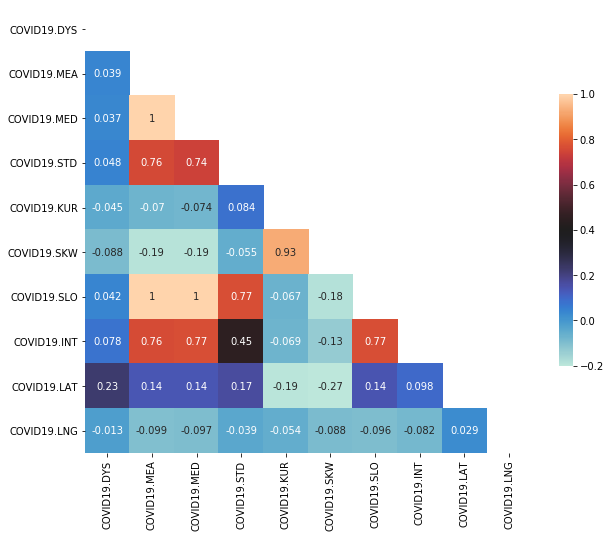

In [71]:
# correlation matrix
corr = covid19_global_data_slope.iloc[:,1:].corr()
# create figure
f, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# plot correalation matrix
sns.heatmap(corr, mask=mask, vmin = -0.2, vmax=1, center=0.4, square=True, cbar_kws={"shrink": .5}, annot=True)
# seaborn issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

From the correlation matrix above, an interesting fact shows up. Number of days elapsed (COVID19.DYS) from min to max (5%-95%), founds its highest correlation with latitude value (COVID19.LAT)

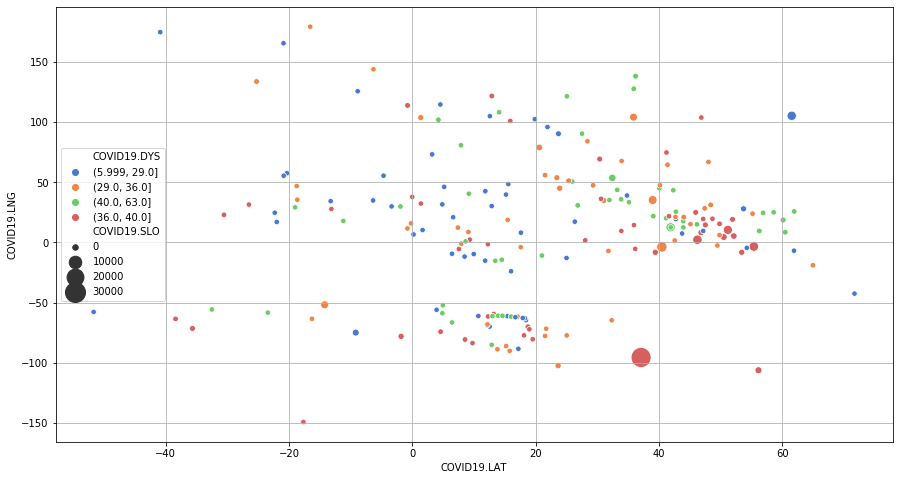

In [80]:
# scatter plot
f, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(y=covid19_global_data_slope['COVID19.LNG'],
                x=covid19_global_data_slope['COVID19.LAT'], 
                hue=pd.qcut(covid19_global_data_slope['COVID19.DYS'],4), 
                size=covid19_global_data_slope['COVID19.SLO'], sizes=(30,400),
                alpha=1, palette='muted',
                ax=ax
               )
ax.grid(True)

In [81]:
covid19_global_data_slope.sort_values(by=['COVID19.SLO'],ascending=False)[0:10]

,iso3_cc,COVID19.DYS,COVID19.MEA,COVID19.MED,COVID19.STD,COVID19.KUR,COVID19.SKW,COVID19.SLO,COVID19.INT,COVID19.LAT,COVID19.LNG
181,USA,37,28159.657143,28680.0,4380.247891,0.047441,-0.601098,29012.077051,28661.288762,37.090240,-95.712891
55,ESP,36,5596.117647,5372.5,2114.295151,-0.464062,-0.329511,5984.026126,7937.403904,40.463667,-3.749220
63,GBR,37,4559.857143,4451.0,1193.360040,3.111713,0.853565,4750.277146,-849.934566,55.378051,-3.435973
60,FRA,39,4038.405405,3665.0,4436.749877,20.166500,4.104290,4609.493927,-4684.794872,46.227638,2.213749
148,RUS,26,4455.583333,4779.5,1967.965025,-1.133817,-0.206273,4397.258803,-7916.735043,61.524010,105.318756
88,ITA,47,4115.844444,4050.0,1132.852493,-0.761517,0.308182,4293.550301,13488.300532,41.871940,12.567380
46,DEU,40,3794.368421,3814.5,1679.107653,-0.805307,0.383834,4117.637336,12166.871951,51.165691,10.451526
176,TUR,33,3495.870968,3148.0,950.210213,-1.067607,-0.057953,3789.367313,551.335116,38.963745,35.243322
34,CHN,34,2307.656250,1976.5,2796.806700,14.348550,3.335292,2614.953400,8113.033613,35.861660,104.195397
25,BRA,32,2845.533333,2120.5,1776.020828,0.344672,1.045340,2574.223424,-4074.681818,-14.235004,-51.925280


From the numbers above, countries who suffer the virus at first glance (ITA, DEU), hit hard. But those countries that hit right after the first wave (USA, ESP, FRA, GBR) hits even harder. And there's even a third wave (RUS, BRA) which could be even worst that the two preceeding ones.

# feature_eng: source 2 (world data indicators)

In [97]:
# Read WDI data indicators
wdi_data = pd.read_csv('WDIData.csv')
# To ease indicators codes readout, a separate file contains its coding scheme
wdi_cets = pd.read_excel('WDI_CETS.xls', sheet_name='WDI series')

In [98]:
# Check topics available
topic_full_list = wdi_cets['Topic'].unique()
topic_full_list

array(['Environment', 'Economic Policy & Debt', 'Infrastructure',
       'Financial Sector', 'Public Sector', 'Private Sector & Trade',
       'Social Protection & Labor', 'Education', 'Gender', 'Health',
       'Poverty'], dtype=object)

In [103]:
# Check indicators available
indicator_list = pd.DataFrame()

for topic in topic_full_list:
    topic_indicator = wdi_cets[wdi_cets['Topic']==topic][['Series Code','Series Name','Topic','SubTopic1']]
    indicator_list = indicator_list.append(topic_indicator)

indicator_list

,Series Code,Series Name,Topic,SubTopic1
0,AG.AGR.TRAC.NO,"Agricultural machinery, tractors",Environment,Agricultural production
1,AG.CON.FERT.PT.ZS,Fertilizer consumption (% of fertilizer produc...,Environment,Agricultural production
2,AG.CON.FERT.ZS,Fertilizer consumption (kilograms per hectare ...,Environment,Agricultural production
3,AG.LND.AGRI.K2,Agricultural land (sq. km),Environment,Land use
4,AG.LND.AGRI.ZS,Agricultural land (% of land area),Environment,Land use
...,...,...,...,...
1182,SI.POV.URHC,Urban poverty headcount ratio at national pove...,Poverty,Poverty rates
1183,SI.SPR.PC40,"Survey mean consumption or income per capita, ...",Poverty,Shared prosperity
1184,SI.SPR.PC40.ZG,Annualized average growth rate in per capita r...,Poverty,Shared prosperity
1185,SI.SPR.PCAP,"Survey mean consumption or income per capita, ...",Poverty,Shared prosperity


In [100]:
# Store all topic indicators from a specified year for each country
# if and only if there's a minimum of countries reporting, otherwise
# results for that indicaor will be discarded

year='2018'
min_report = 100

dut = pd.DataFrame(covid19_global_data_cc[['iso3_cc','iso2_cc','latitude','longitude']])
dut.rename(columns={'iso3_cc':'Country Code'}, inplace=True)

for indicator,name in zip(indicator_list['Series Code'], indicator_list['Series Name']):
    dut_cc = wdi_data[wdi_data['Indicator Code'] == indicator][['Country Code',year]]
    if((dut_cc[year].count()) > min_report):
        dut = pd.merge(left=dut,right=dut_cc,on='Country Code')
        dut.rename(columns={year:indicator}, inplace=True)
        print('{}={}\t ({}) '.format(indicator,dut_cc[year].count(),name),end='\n')

AG.LND.TOTL.K2=256	 (Land area (sq. km)) 
AG.SRF.TOTL.K2=256	 (Surface area (sq. km)) 
EN.BIR.THRD.NO=260	 (Bird species, threatened) 
EN.FSH.THRD.NO=260	 (Fish species, threatened) 
EN.HPT.THRD.NO=260	 (Plant species (higher), threatened) 
EN.MAM.THRD.NO=260	 (Mammal species, threatened) 
EN.POP.DNST=255	 (Population density (people per sq. km of land area)) 
EN.URB.LCTY=152	 (Population in largest city) 
EN.URB.LCTY.UR.ZS=194	 (Population in the largest city (% of urban population)) 
EN.URB.MCTY=121	 (Population in urban agglomerations of more than 1 million) 
EN.URB.MCTY.TL.ZS=157	 (Population in urban agglomerations of more than 1 million (% of total population)) 
ER.LND.PTLD.ZS=257	 (Terrestrial protected areas (% of total land area)) 
ER.MRN.PTMR.ZS=204	 (Marine protected areas (% of territorial waters)) 
ER.PTD.TOTL.ZS=256	 (Terrestrial and marine protected areas (% of total territorial area)) 
SP.RUR.TOTL=260	 (Rural population) 
SP.RUR.TOTL.ZG=250	 (Rural population growth (an

DT.NFL.IFAD.CD=144	 (Net official flows from UN agencies, IFAD (current US$)) 
DT.NFL.ILOG.CD=174	 (Net official flows from UN agencies, ILO (current US$)) 
DT.NFL.IMFC.CD=133	 (Net financial flows, IMF concessional (NFL, current US$)) 
DT.NFL.IMFN.CD=133	 (Net financial flows, IMF nonconcessional (NFL, current US$)) 
DT.NFL.MIBR.CD=133	 (Net financial flows, IBRD (NFL, current US$)) 
DT.NFL.MIDA.CD=133	 (Net financial flows, IDA (NFL, current US$)) 
DT.NFL.MLAT.CD=133	 (Net financial flows, multilateral (NFL, current US$)) 
DT.NFL.MOTH.CD=133	 (Net financial flows, others (NFL, current US$)) 
DT.NFL.NIFC.CD=133	 (IFC, private nonguaranteed (NFL, current US$)) 
DT.NFL.OFFT.CD=133	 (PPG, official creditors (NFL, current US$)) 
DT.NFL.PBND.CD=133	 (PPG, bonds (NFL, current US$)) 
DT.NFL.PCBK.CD=133	 (PPG, commercial banks (NFL, current US$)) 
DT.NFL.PCBO.CD=133	 (Commercial banks and other lending (PPG + PNG) (NFL, current US$)) 
DT.NFL.PNGB.CD=133	 (PNG, bonds (NFL, current US$)) 
DT.NF

NV.IND.MANF.KD.ZG=181	 (Manufacturing, value added (annual % growth)) 
NV.IND.MANF.KN=154	 (Manufacturing, value added (constant LCU)) 
NV.IND.MANF.ZS=191	 (Manufacturing, value added (% of GDP)) 
NV.IND.TOTL.CD=206	 (Industry, value added (current US$)) 
NV.IND.TOTL.CN=170	 (Industry, value added (current LCU)) 
NV.IND.TOTL.KD=202	 (Industry, value added (constant 2010 US$)) 
NV.IND.TOTL.KD.ZG=206	 (Industry, value added (annual % growth)) 
NV.IND.TOTL.KN=168	 (Industry, value added (constant LCU)) 
NV.IND.TOTL.ZS=207	 (Industry, value added (% of GDP)) 
NY.EXP.CAPM.KN=151	 (Exports as a capacity to import (constant LCU)) 
NY.GDP.DISC.CN=154	 (Discrepancy in expenditure estimate of GDP (current LCU)) 
NY.GDP.DISC.KN=118	 (Discrepancy in expenditure estimate of GDP (constant LCU)) 
NY.GDP.FCST.CD=183	 (Gross value added at factor cost (current US$)) 
NY.GDP.FCST.CN=157	 (Gross value added at factor cost (current LCU)) 
NY.GDP.FCST.KD=178	 (Gross value added at factor cost (constant 201

IQ.CPA.IRAI.XQ=111	 (IDA resource allocation index (1=low to 6=high)) 
IQ.CPA.MACR.XQ=111	 (CPIA macroeconomic management rating (1=low to 6=high)) 
IQ.CPA.PADM.XQ=111	 (CPIA quality of public administration rating (1=low to 6=high)) 
IQ.CPA.PRES.XQ=111	 (CPIA equity of public resource use rating (1=low to 6=high)) 
IQ.CPA.PROP.XQ=111	 (CPIA property rights and rule-based governance rating (1=low to 6=high)) 
IQ.CPA.PROT.XQ=111	 (CPIA social protection rating (1=low to 6=high)) 
IQ.CPA.PUBS.XQ=111	 (CPIA public sector management and institutions cluster average (1=low to 6=high)) 
IQ.CPA.REVN.XQ=111	 (CPIA efficiency of revenue mobilization rating (1=low to 6=high)) 
IQ.CPA.SOCI.XQ=111	 (CPIA policies for social inclusion/equity cluster average (1=low to 6=high)) 
IQ.CPA.STRC.XQ=111	 (CPIA structural policies cluster average (1=low to 6=high)) 
IQ.CPA.TRAD.XQ=111	 (CPIA trade rating (1=low to 6=high)) 
IQ.CPA.TRAN.XQ=111	 (CPIA transparency, accountability, and corruption in the public

TM.VAL.AGRI.ZS.UN=163	 (Agricultural raw materials imports (% of merchandise imports)) 
TM.VAL.FOOD.ZS.UN=163	 (Food imports (% of merchandise imports)) 
TM.VAL.FUEL.ZS.UN=163	 (Fuel imports (% of merchandise imports)) 
TM.VAL.INSF.ZS.WT=202	 (Insurance and financial services (% of commercial service imports)) 
TM.VAL.MANF.ZS.UN=163	 (Manufactures imports (% of merchandise imports)) 
TM.VAL.MMTL.ZS.UN=163	 (Ores and metals imports (% of merchandise imports)) 
TM.VAL.MRCH.AL.ZS=250	 (Merchandise imports from economies in the Arab World (% of total merchandise imports)) 
TM.VAL.MRCH.CD.WT=245	 (Merchandise imports (current US$)) 
TM.VAL.MRCH.HI.ZS=251	 (Merchandise imports from high-income economies (% of total merchandise imports)) 
TM.VAL.MRCH.OR.ZS=251	 (Merchandise imports from low- and middle-income economies outside region (% of total merchandise imports)) 
TM.VAL.MRCH.R1.ZS=251	 (Merchandise imports from low- and middle-income economies in East Asia & Pacific (% of total merchandi

SL.TLF.CACT.FE.NE.ZS=111	 (Labor force participation rate, female (% of female population ages 15+) (national estimate)) 
SL.TLF.CACT.FE.ZS=233	 (Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)) 
SL.TLF.CACT.FM.NE.ZS=111	 (Ratio of female to male labor force participation rate (%) (national estimate)) 
SL.TLF.CACT.FM.ZS=233	 (Ratio of female to male labor force participation rate (%) (modeled ILO estimate)) 
SL.TLF.CACT.MA.NE.ZS=111	 (Labor force participation rate, male (% of male population ages 15+) (national estimate)) 
SL.TLF.CACT.MA.ZS=233	 (Labor force participation rate, male (% of male population ages 15+) (modeled ILO estimate)) 
SL.TLF.CACT.NE.ZS=112	 (Labor force participation rate, total (% of total population ages 15+) (national estimate)) 
SL.TLF.CACT.ZS=233	 (Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)) 
SL.TLF.TOTL.FE.ZS=232	 (Labor force, female (% of total labor force)) 

SH.HIV.ARTC.ZS=160	 (Antiretroviral therapy coverage (% of people living with HIV)) 
SH.HIV.INCD=138	 (Adults (ages 15+) newly infected with HIV) 
SH.HIV.INCD.14=103	 (Children (ages 0-14) newly infected with HIV) 
SH.HIV.INCD.TL=140	 (Adults (ages 15+) and children (ages 0-14) newly infected with HIV) 
SH.HIV.INCD.ZS=157	 (Incidence of HIV (% of uninfected population ages 15-49)) 
SH.HIV.PMTC.ZS=105	 (Antiretroviral therapy coverage for PMTCT (% of pregnant women living with HIV)) 
SH.IMM.HEPB=230	 (Immunization, HepB3 (% of one-year-old children)) 
SH.IMM.IDPT=238	 (Immunization, DPT (% of children ages 12-23 months)) 
SH.IMM.MEAS=238	 (Immunization, measles (% of children ages 12-23 months)) 
SH.TBS.DTEC.ZS=221	 (Tuberculosis case detection rate (%, all forms)) 
SH.TBS.INCD=228	 (Incidence of tuberculosis (per 100,000 people)) 
SH.VAC.TTNS.ZS=134	 (Newborns protected against tetanus (%)) 
SP.ADO.TFRT=196	 (Adolescent fertility rate (births per 1,000 women ages 15-19)) 
SP.DYN.AMRT.F

In [106]:
wdi_globalind_data = dut
wdi_globalind_data

,Country Code,iso2_cc,latitude,longitude,AG.LND.TOTL.K2,AG.SRF.TOTL.K2,EN.BIR.THRD.NO,EN.FSH.THRD.NO,EN.HPT.THRD.NO,EN.MAM.THRD.NO,...,SP.POP.7579.FE.5Y,SP.POP.7579.MA.5Y,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA.5Y,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.ZS
0,ABW,AW,12.521110,-69.968338,180.0,180.0,2.0,24.0,2.0,2.0,...,2.611417,2.032083,2.857811,1.727569,45.673626,19.740156,25.933470,0.453576,105845.0,52.531036
1,AFG,AF,33.939110,67.709953,652860.0,652860.0,16.0,4.0,5.0,11.0,...,0.449182,0.370219,0.320982,0.233326,84.077656,4.758273,79.319383,2.384761,37172386.0,48.635847
2,AGO,AO,-11.202692,17.873887,1246700.0,1246700.0,32.0,53.0,34.0,18.0,...,0.431691,0.310220,0.337249,0.207533,96.175740,4.347985,91.827756,3.276134,30809762.0,50.530463
3,ALB,AL,41.153332,20.168331,27400.0,28750.0,8.0,44.0,4.0,3.0,...,2.996764,2.706800,3.033954,2.448079,45.810037,20.041214,25.768823,-0.246732,2866376.0,49.063095
4,AND,AD,42.546245,1.601554,470.0,470.0,3.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006493,77006.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,VNM,VN,14.058324,108.277199,310070.0,331230.0,52.0,83.0,231.0,56.0,...,1.444917,0.877432,2.634749,1.279016,43.776605,10.459717,33.316888,0.992716,95540395.0,50.096410
189,YEM,YE,15.552727,48.516388,527970.0,527970.0,16.0,40.0,163.0,11.0,...,0.526174,0.411991,0.416135,0.283628,73.886314,5.001439,68.884875,2.357023,28498687.0,49.611657
190,ZAF,ZA,-30.559482,22.937506,1213090.0,1219090.0,54.0,121.0,153.0,30.0,...,1.187388,0.722917,0.973072,0.463873,52.433201,8.106405,44.326796,1.357697,57779622.0,50.694150
191,ZMB,ZM,-13.133897,27.849332,743390.0,752610.0,20.0,20.0,23.0,13.0,...,0.454583,0.262378,0.351255,0.154687,88.806844,3.964332,84.842512,2.912801,17351822.0,50.493208


In [108]:
# store results in csv file
wdi_globalind_data.to_csv('wdi_globalind_data.csv',index=False)